# **Denoising Diffusion Probabilistic Models with MiniAi**

Our custom training library should now allow us to begin building Stable Diffusion from scratch.

We'll be working with the seminal 2020 paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (DDPM) which greatly simplified the training and generation process for these models which were [originally invented in 2015](https://arxiv.org/abs/1503.03585).

In [2]:
import pickle,gzip,math,os,time,shutil,random,logging
import fastcore.all as fc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

## **Load Dataset**

In [4]:
x, y = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

We will resize the `28x28` images to `32x32` to make life easier with regard to model architecures.

In [5]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32, 32)) for o in b[x]]

In [6]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
# Training data and batchify
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

## **Create the DDP Model**

We will be working with a [UNet](https://huggingface.co/docs/diffusers/en/api/models/unet2d), which in essence has an architecture which _"consists of a contracting path to capture context and a symmetric expanding path that enables precise localization."_

It is important to note that we will be using the _unconditional model_ for this exercise. Additional tricks like attention mechanisms will be discussed in upcoming NBs.

The model architecture is represented as:

<img src="https://huggingface.co/blog/assets/78_annotated-diffusion/unet_architecture.jpg" width="700">

In [7]:
from diffusers import UNet2DModel

In [8]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

### **Training the Model Using a Callback**

The DDPM training process can be summarized as:

1. Randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to the timestep to the original image.
   - The variance of the noise increases with increasing timesteps.
3. Pass the noisy image and the timestep to the model.
4. Train the model, using an MSE loss between the model output and the amount of noise added to the image.
5. Our callback executes steps 1 and 2 before setting up the input and ground truth tensors.
6. The callback carries out steps 3 and 4, a sample is selected from this model which begins an iterative denoising process from pure noise.
    - Predicted noise is removed by the model, using an expected noise schedule which is the reverse of what was used during the training process.
  
Against coding conventions, we will be using greek letters in the model callback to allow us to replicate the math as closely as possible. 

The final version's objects will have standard naming.

In [9]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # The variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample # elements of tuple are unpacked and passed to the model
                                                                                # .sample comes from the HuggingFace framework
    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # target noise, x_T, to be predicted
        x0 = learn.batch[0] # contains original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

In [11]:
# Create learner and specify the number of timesteps and the min and max variance
# for the model
lr = 1e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.103,0,train
0.030,0,eval
0.023,1,train
0.021,1,eval
0.020,2,train
0.019,2,eval
0.018,3,train
0.017,3,eval
0.017,4,train
0.016,4,eval


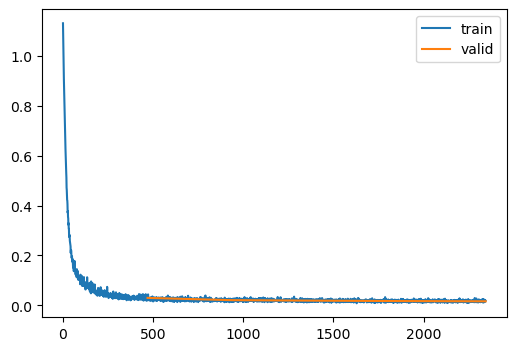

In [12]:
learn.fit(epochs)

In [13]:
# Saving model
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [14]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [15]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

## **Inference**

In [16]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000

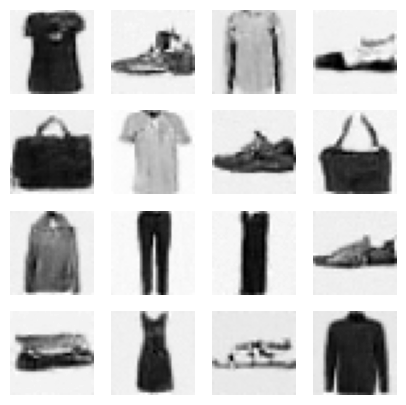

In [17]:
show_images(-samples[-1], figsize=(5,5))

Using matplotlib backend: module://matplotlib_inline.backend_inline


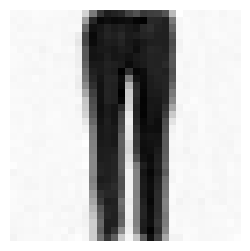

In [18]:
# Visualize the sampling process
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig, ax = plt.subplots(figsize=(3, 3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800, 990, 5) + L.range(990, 1000) + [999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=4000)
display(HTML(animate.to_html5_video()))